# Clock Protein Data Exploration


In [1]:
import pandas as pd

In [2]:
###############################################################################
#
#   get all pairwise PPI scores for the AF and RF datasets
#
#   creates `clock_RF_scores.csv` from `RF_scores` and
#               `clock_AF_scores.csv` from `AF_scores`
#
###############################################################################

# Load data mapping gene names to UniProt codes
clock_genes_uniprot_df = pd.read_csv("./data/clock_uniprot_codes.csv")
hallmark_genes_uniprot_df = pd.read_csv("./data/hallmark_uniprot_codes.csv")

# Extract UniProt codes
clock_codes_dict = clock_genes_uniprot_df.set_index("gene_name").to_dict()[
    "uniprot_code"
]
hallmark_codes_dict = hallmark_genes_uniprot_df.set_index("gene_name").to_dict()[
    "uniprot_code"
]


# Generate all combinations of clock-clock and clock-hallmark pairs
def create_pairs(first_codes, second_codes):
    return {
        f"{first_gene}_{second_gene}": f"{first_codes[first_gene]}_{second_codes[second_gene]}"
        for first_gene in first_codes
        for second_gene in second_codes
    }


# Clock gene pairs (clock-clock)
clock_pairs = create_pairs(clock_codes_dict, clock_codes_dict)

# Clock-hallmark gene pairs (clock-hallmark, hallmark-clock)
clock_hallmark_pairs = (
    create_pairs(clock_codes_dict, hallmark_codes_dict)
    | create_pairs(hallmark_codes_dict, clock_codes_dict)
    | clock_pairs
)

print("clock pairs:")
print(clock_pairs)

print("\nclock-hallmark pairs:")
print(clock_hallmark_pairs)

clock pairs:
{'PER1_PER1': 'O15534_O15534', 'PER1_PER2': 'O15534_O15055', 'PER1_PER3': 'O15534_P56645', 'PER1_RORA': 'O15534_P35398', 'PER1_RORB': 'O15534_Q92753', 'PER1_RORC': 'O15534_P51449', 'PER1_CRY1': 'O15534_Q16526', 'PER1_CRY2': 'O15534_Q49AN0', 'PER1_NR1D1': 'O15534_P20393', 'PER1_NR1D2': 'O15534_Q14995', 'PER1_CLOCK': 'O15534_O15516', 'PER1_NPAS2': 'O15534_Q99743', 'PER1_ARNTL': 'O15534_O00327', 'PER1_ARNTL2': 'O15534_Q8WYA1', 'PER2_PER1': 'O15055_O15534', 'PER2_PER2': 'O15055_O15055', 'PER2_PER3': 'O15055_P56645', 'PER2_RORA': 'O15055_P35398', 'PER2_RORB': 'O15055_Q92753', 'PER2_RORC': 'O15055_P51449', 'PER2_CRY1': 'O15055_Q16526', 'PER2_CRY2': 'O15055_Q49AN0', 'PER2_NR1D1': 'O15055_P20393', 'PER2_NR1D2': 'O15055_Q14995', 'PER2_CLOCK': 'O15055_O15516', 'PER2_NPAS2': 'O15055_Q99743', 'PER2_ARNTL': 'O15055_O00327', 'PER2_ARNTL2': 'O15055_Q8WYA1', 'PER3_PER1': 'P56645_O15534', 'PER3_PER2': 'P56645_O15055', 'PER3_PER3': 'P56645_P56645', 'PER3_RORA': 'P56645_P35398', 'PER3_RORB':

In [3]:
# Load RF and AF scores data (tab-separated)
RF_scores_df = pd.read_csv("./data/RF_scores", sep="\t", header=None)
AF_scores_df = pd.read_csv("./data/AF_scores", sep="\t", header=None)

RF_scores_df.columns = ["uniprot_pairs", "score"]
AF_scores_df.columns = ["uniprot_pairs", "score"]

RF_sorted_df = RF_scores_df.sort_values(by="score", ascending=False)
AF_sorted_df = AF_scores_df.sort_values(by="score", ascending=False)

RF_sorted_df.to_csv("./data/RF_scores.csv", index=False)
AF_sorted_df.to_csv("./data/AF_scores.csv", index=False)

In [27]:
# pairs_df = pd.DataFrame(
#     list(clock_pairs.items()), columns=["gene_pairs", "uniprot_pairs"]
# )

# # filtered_df = RF_scores_df[RF_scores_df[0] == pairs_df["uniprot_pairs"]]
# filtered_df = RF_scores_df[RF_scores_df[0].isin(pairs_df["uniprot_pairs"].tolist())]

# # test = filtered_df.copy()

# filtered_df.columns = ["uniprot_pairs", "score"]


# # print(RF_scores_df[0], end="\n\n")
# # print(pairs_df["uniprot_pairs"], end="\n\n")
# # print(filtered_df, end="\n\n")
# # print(test, end="\n\n")

# merged_df = pd.merge(pairs_df, filtered_df, on="uniprot_pairs")
# # print(merged_df, end="\n\n")

# sorted_df = merged_df.sort_values(by="gene_pairs")
# print(sorted_df, end="\n\n")

In [5]:
# process and save pairwise scores
def process_and_save_scores(df, pairs, filename_name, filename_score):
    # Create a DataFrame from the pairs dictionary
    pairs_df = pd.DataFrame(
        list(pairs.items()), columns=["gene_pairs", "uniprot_pairs"]
    )

    # Filter the original dataframe to only include rows where gene pairs match
    filtered_df = df[df["uniprot_pairs"].isin(pairs_df["uniprot_pairs"].tolist())]

    # Merge the pairs_df with the filtered dataframe to add gene_pairs column
    merged_df = pd.merge(pairs_df, filtered_df, on="uniprot_pairs")

    # print(merged_df)

    # Add swapped entries
    swapped_df = merged_df.copy()
    swapped_df["gene_pairs"] = merged_df["gene_pairs"].apply(
        lambda x: "_".join(x.split("_")[::-1])
    )
    swapped_df["uniprot_pairs"] = merged_df["uniprot_pairs"].apply(
        lambda x: "_".join(x.split("_")[::-1])
    )

    # Combine original and swapped entries
    combined_df = pd.concat([merged_df, swapped_df], ignore_index=True)

    print(combined_df)

    # Sort by gene pairs
    sorted_name_df = combined_df.sort_values(by="gene_pairs")

    # Save the resulting dataframe to a CSV
    sorted_name_df.to_csv(filename_name, index=False)

    # Sort by score
    sorted_score_df = combined_df.sort_values(by="score", ascending=False)

    # Save the resulting dataframe to a CSV
    sorted_score_df.to_csv(filename_score, index=False)


# Process and save RF scores for clock-clock and clock-hallmark pairs
process_and_save_scores(
    RF_scores_df,
    clock_pairs,
    "./output/clock_RF_scores.csv",
    "./output/clock_RF_scores_sorted.csv",
)
process_and_save_scores(
    RF_scores_df,
    clock_hallmark_pairs,
    "./output/clock_hallmark_RF_scores.csv",
    "./output/clock_hallmark_RF_scores_sorted.csv",
)

# Process and save AF scores for clock-clock and clock-hallmark pairs
process_and_save_scores(
    AF_scores_df,
    clock_pairs,
    "./output/clock_AF_scores.csv",
    "./output/clock_AF_scores_sorted.csv",
)
process_and_save_scores(
    AF_scores_df,
    clock_hallmark_pairs,
    "./output/clock_hallmark_AF_scores.csv",
    "./output/clock_hallmark_AF_scores_sorted.csv",
)

       gene_pairs  uniprot_pairs   score
0       PER1_PER3  O15534_P56645  0.1525
1       PER1_RORB  O15534_Q92753  0.2334
2       PER1_RORC  O15534_P51449  0.1687
3       PER1_CRY1  O15534_Q16526  0.1313
4       PER1_CRY2  O15534_Q49AN0  0.1254
..            ...            ...     ...
163   CLOCK_ARNTL  O15516_O00327  0.9907
164   NPAS2_ARNTL  Q99743_O00327  0.9966
165  ARNTL2_ARNTL  Q8WYA1_O00327  0.1800
166   RORB_ARNTL2  Q92753_Q8WYA1  0.0956
167  NPAS2_ARNTL2  Q99743_Q8WYA1  0.9950

[168 rows x 3 columns]
         gene_pairs  uniprot_pairs   score
0          PER1_MAX  O15534_P61244  0.1620
1         PER1_EZH2  O15534_Q15910  0.1769
2         PER1_NONO  O15534_Q15233  0.1858
3    PER1_HNRNPA2B1  O15534_P22626  0.0950
4        PER1_CHEK2  O15534_O96017  0.2063
..              ...            ...     ...
573     CLOCK_ARNTL  O15516_O00327  0.9907
574     NPAS2_ARNTL  Q99743_O00327  0.9966
575    ARNTL2_ARNTL  Q8WYA1_O00327  0.1800
576     RORB_ARNTL2  Q92753_Q8WYA1  0.0956
577    NPAS

In [6]:
###############################################################################
#
#   create pairwise tables for all gene pairs
#
#   uses `clock_RF_scores.csv` to create `clock_RF_score_matrix_unsorted.csv`
#   and `clock_RF_score_matrix_sorted.csv`, and `clock_AF_scores.csv` to create
#   `clock_AF_score_matrix_unsorted.csv` and `clock_AF_score_matrix_sorted.csv`
#
###############################################################################

import pandas as pd

# Load and concatenate clock and hallmark gene UniProt data
clock_genes_uniprot_df = pd.read_csv("./data/clock_uniprot_codes.csv")
hallmark_genes_uniprot_df = pd.read_csv("./data/hallmark_uniprot_codes.csv")
genes_uniprot_df = pd.concat([clock_genes_uniprot_df, hallmark_genes_uniprot_df])

# Create a dictionary mapping UniProt codes to gene names
genes_uniprot_map = dict(
    zip(genes_uniprot_df["uniprot_code"], genes_uniprot_df["gene_name"])
)


# Function to split gene pairs, pivot scores into a matrix, and save to CSV
def create_score_matrix(scores_df, output_file_unsorted, output_file_sorted):
    # Split gene pairs into separate columns
    scores_df[["gene_1", "gene_2"]] = scores_df["gene_pairs"].str.split(
        "_", expand=True
    )

    # Create a pivot table to convert long-form data into a matrix
    score_matrix_df = pd.pivot_table(
        scores_df, values="score", index="gene_1", columns="gene_2"
    )

    # Rename rows and columns using UniProt gene names
    score_matrix_df.rename(
        index=genes_uniprot_map, columns=genes_uniprot_map, inplace=True
    )
    score_matrix_df.index.name = None
    score_matrix_df.columns.name = None

    # Save the unsorted matrix
    score_matrix_df.to_csv(output_file_unsorted, index=True, index_label=None)

    # Sort the matrix by gene names and save the sorted matrix
    sorted_matrix_df = score_matrix_df.sort_index(axis=0).sort_index(axis=1)
    sorted_matrix_df.to_csv(output_file_sorted, index=True, index_label=None)


# Process RF and AF score matrices for clock-clock and clock-hallmark pairs
def process_scores(input_file, output_file_unsorted, output_file_sorted):
    scores_df = pd.read_csv(input_file)
    create_score_matrix(scores_df, output_file_unsorted, output_file_sorted)


# Process RF scores for clock-clock and clock-hallmark pairs
process_scores(
    "./output/clock_RF_scores.csv",
    "./output/clock_RF_score_matrix_unsorted.csv",
    "./output/clock_RF_score_matrix_sorted.csv",
)
process_scores(
    "./output/clock_hallmark_RF_scores.csv",
    "./output/clock_hallmark_RF_score_matrix_unsorted.csv",
    "./output/clock_hallmark_RF_score_matrix_sorted.csv",
)

# Process AF scores for clock-clock and clock-hallmark pairs
process_scores(
    "./output/clock_AF_scores.csv",
    "./output/clock_AF_score_matrix_unsorted.csv",
    "./output/clock_AF_score_matrix_sorted.csv",
)
process_scores(
    "./output/clock_hallmark_AF_scores.csv",
    "./output/clock_hallmark_AF_score_matrix_unsorted.csv",
    "./output/clock_hallmark_AF_score_matrix_sorted.csv",
)

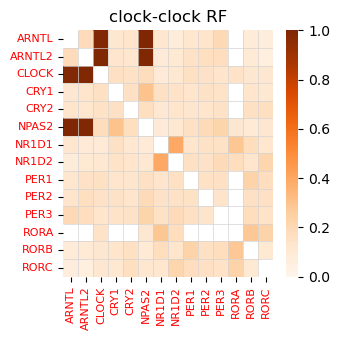

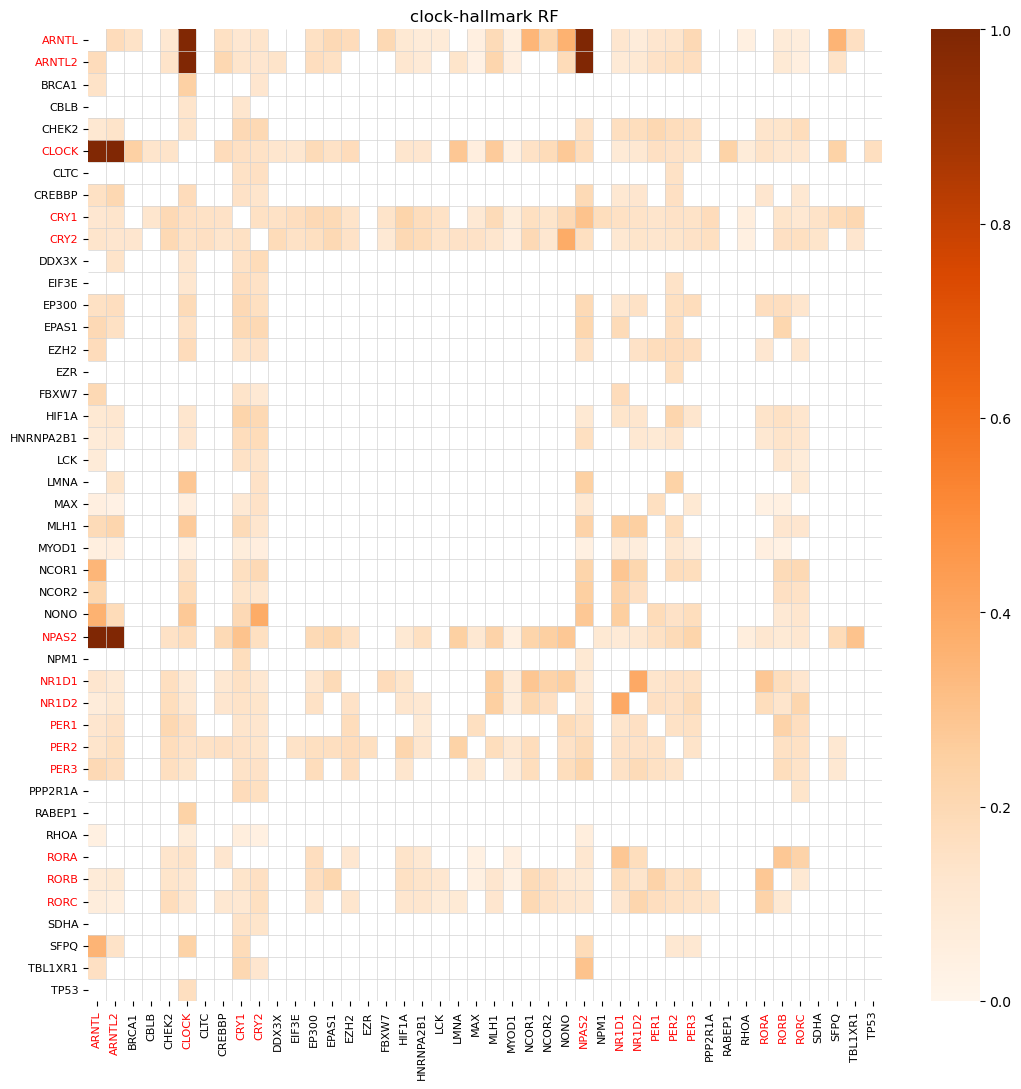

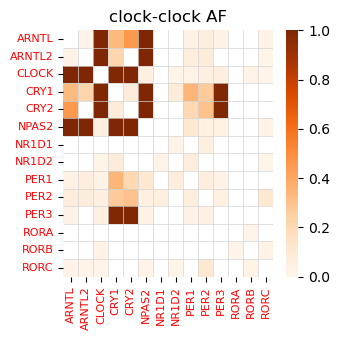

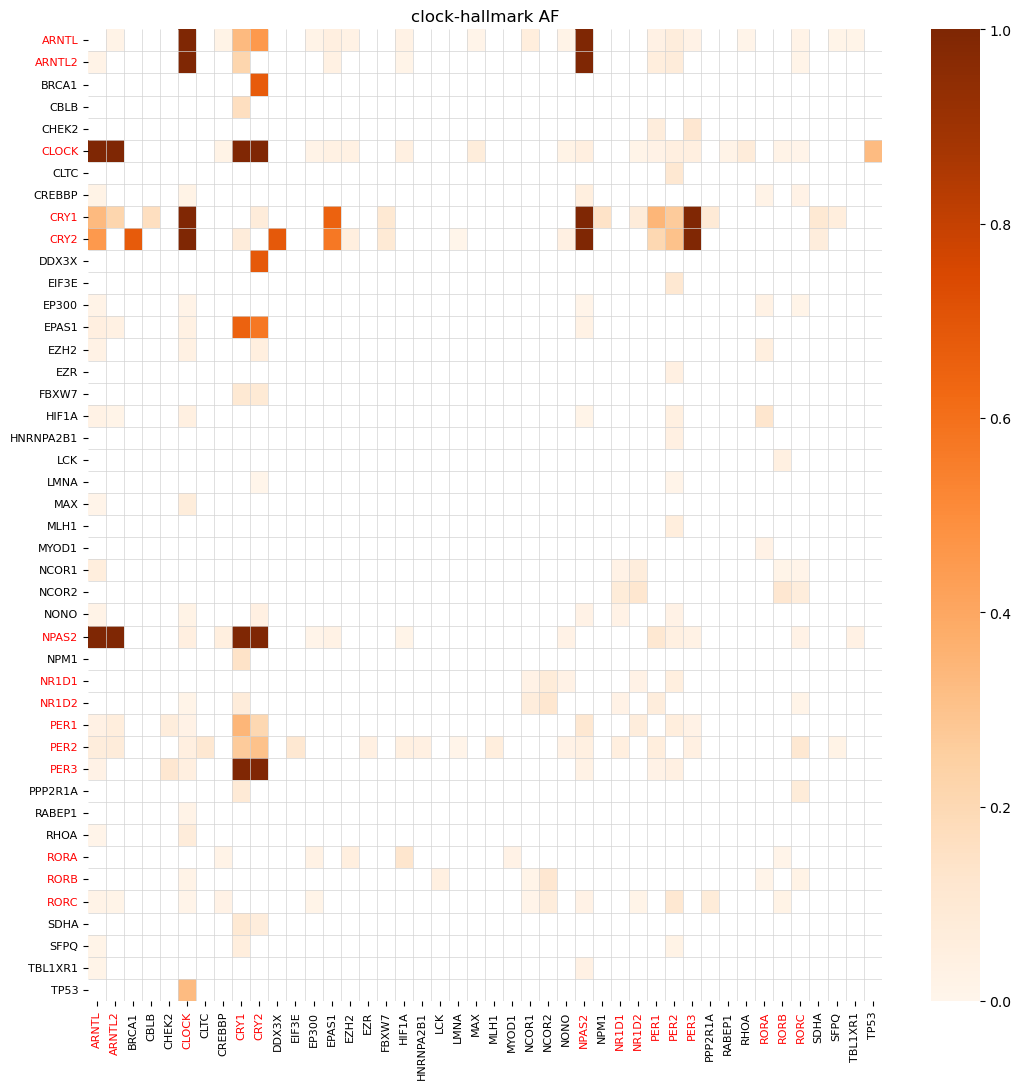

In [7]:
###############################################################################
#
#   generate clock-clock and clock-hallmark heatmap
#
###############################################################################

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Function to generate a color palette for the heatmap
def palette(color="seagreen"):
    return sns.light_palette(color, as_cmap=True)


# Load clock gene names from UniProt data
clock_genes = list(pd.read_csv("./data/clock_uniprot_codes.csv")["gene_name"])


# Function to create a heatmap and save the image
def create_heatmap(df, title, output_file, color, clock_genes):
    plt.figure(figsize=(len(df) / 4, len(df) / 4))  # Increase figure size

    # Create the heatmap
    # heatmap = sns.heatmap(df, cmap=palette(color), vmin=0, vmax=1)
    heatmap = sns.heatmap(df, cmap="Oranges", vmin=0, vmax=1)
    heatmap.set_title(title, fontsize=12)

    # Change tick label color to grey for non-clock genes
    for tick_label in heatmap.get_yticklabels():
        if tick_label.get_text() in clock_genes:
            tick_label.set_color("red")
    for tick_label in heatmap.get_xticklabels():
        if tick_label.get_text() in clock_genes:
            tick_label.set_color("red")

    # Set font size for tick labels
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

    # Add gridlines
    ax = heatmap.axes  # Get the axes of the heatmap
    ax.hlines(
        y=np.arange(1, len(df.index)),
        xmin=0,
        xmax=len(df.columns),
        color="lightgrey",
        linewidth=0.5,
    )
    ax.vlines(
        x=np.arange(1, len(df.columns)),
        ymin=0,
        ymax=len(df.index),
        color="lightgrey",
        linewidth=0.5,
    )

    # Apply tight layout to avoid cutoff
    plt.tight_layout()

    # Show and save the heatmap
    plt.show()
    fig = heatmap.get_figure()
    fig.savefig(output_file)


# Load data and generate heatmaps for RF and AF scores
def process_heatmaps(score_matrix_file, title, output_file, color, clock_genes):
    # Load the unsorted score matrix as a DataFrame
    df = pd.read_csv(score_matrix_file, index_col=0)
    create_heatmap(df, title, output_file, color, clock_genes)


# Process heatmaps for RF scores
process_heatmaps(
    "./output/clock_RF_score_matrix_unsorted.csv",
    "clock-clock RF",
    "./output/clock-RF-score-heatmap.png",
    "blue",
    clock_genes,
)
process_heatmaps(
    "./output/clock_hallmark_RF_score_matrix_unsorted.csv",
    "clock-hallmark RF",
    "./output/clock-hallmark-RF-score-heatmap.png",
    "blue",
    clock_genes,
)

# Process heatmaps for AF scores
process_heatmaps(
    "./output/clock_AF_score_matrix_unsorted.csv",
    "clock-clock AF",
    "./output/clock-AF-score-heatmap.png",
    "blue",
    clock_genes,
)
process_heatmaps(
    "./output/clock_hallmark_AF_score_matrix_unsorted.csv",
    "clock-hallmark AF",
    "./output/clock-hallmark-AF-score-heatmap.png",
    "blue",
    clock_genes,
)

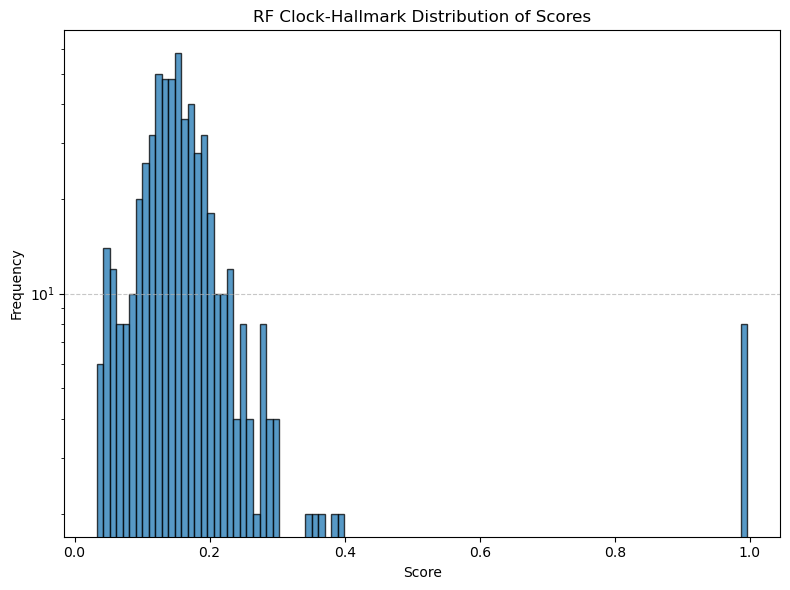

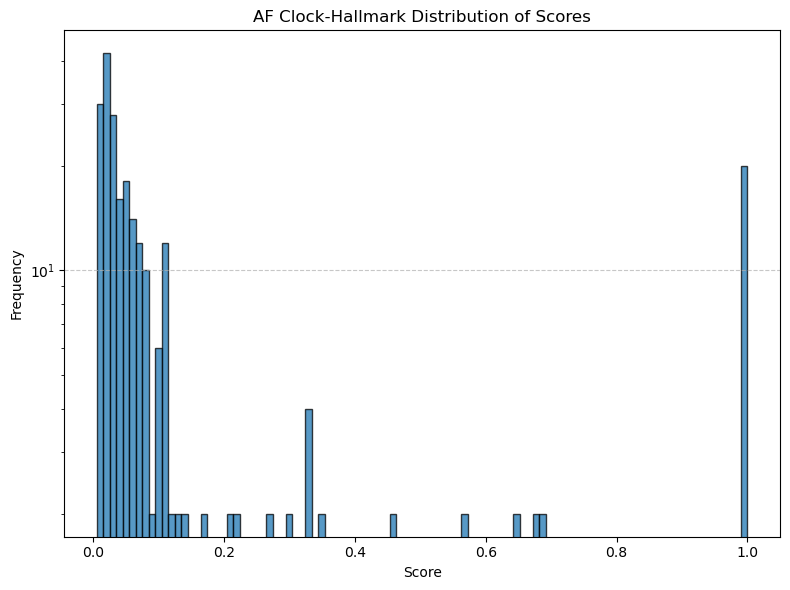

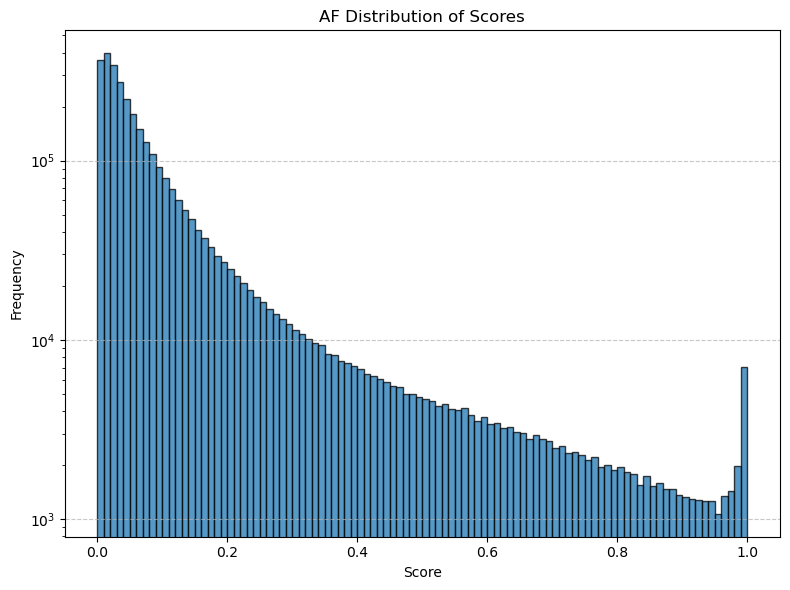

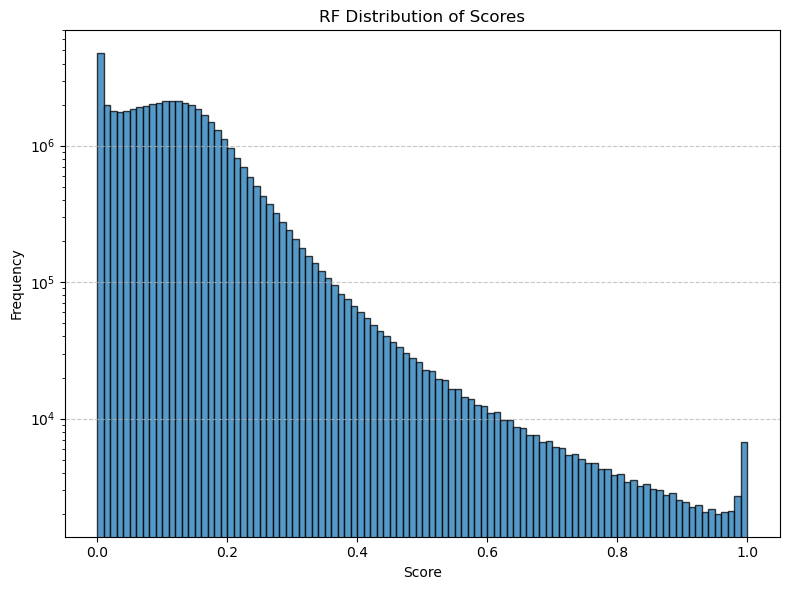

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import math


def plot_histogram(file_path, title, bins=20):
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Extract the 'score' column
    scores = data["score"]

    # Create the histogram
    plt.figure(figsize=(8, 6))
    plt.hist(
        # scores, bins=max(20, int(math.log2(len(scores)))), edgecolor="black", alpha=0.75
        scores,
        bins=100,
        edgecolor="black",
        alpha=0.75,
    )
    plt.title(title)
    plt.yscale("log")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


# File paths and titles for the datasets
datasets = [
    {
        "file_path": "./output/clock_hallmark_RF_scores.csv",
        "title": "RF Clock-Hallmark Distribution of Scores",
    },
    {
        "file_path": "./output/clock_hallmark_AF_scores.csv",
        "title": "AF Clock-Hallmark Distribution of Scores",
    },
    {"file_path": "./data/AF_scores.csv", "title": "AF Distribution of Scores"},
    {"file_path": "./data/RF_scores.csv", "title": "RF Distribution of Scores"},
]

# Loop through datasets and plot histograms
for dataset in datasets:
    plot_histogram(file_path=dataset["file_path"], title=dataset["title"])